Pareto front size: 148


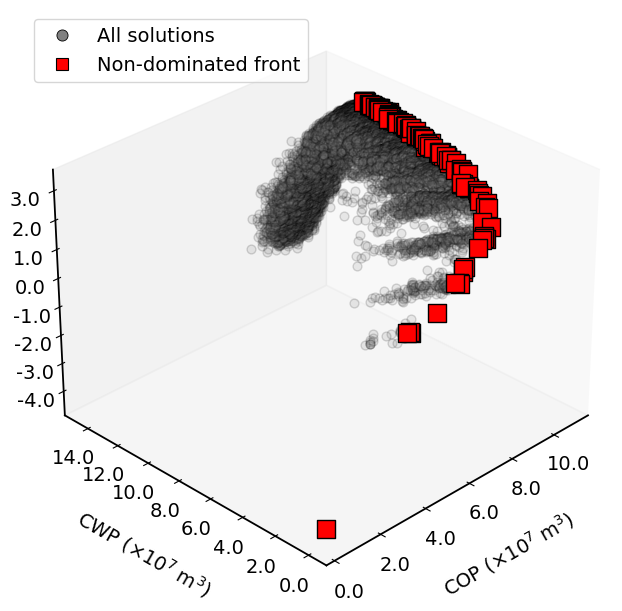

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib.lines import Line2D

# ---------------------------------------------------
# Style FIRST (resets rcParams)
# ---------------------------------------------------
plt.style.use("default")

# ---------------------------------------------------
# Global font configuration (AFTER style)
# ---------------------------------------------------
font_size = 14
mpl.rcParams.update({
    "font.size": font_size,
    "axes.labelsize": font_size,
    "axes.titlesize": font_size,
    "xtick.labelsize": font_size,
    "ytick.labelsize": font_size,
    "legend.fontsize": font_size,
    "axes.linewidth": 1.3,
})

# ---------------------------------------------------
# Load dataset
# ---------------------------------------------------
df = pd.read_csv("datasets/MOU2D.csv", delimiter=";", engine="python")

# Use first THREE objectives
objs = df.values[:, -3:].astype(float)

# ---------------------------------------------------
# Objective directions
# True  -> minimize
# False -> maximize
# ---------------------------------------------------
minimize = np.array([False, True, False])

# ---------------------------------------------------
# Dominance check (mixed objectives)
# ---------------------------------------------------
def dominates(q, p, minimize):
    strictly_better = False

    for k in range(len(p)):
        if minimize[k]:
            if q[k] > p[k]:
                return False
            if q[k] < p[k]:
                strictly_better = True
        else:
            if q[k] < p[k]:
                return False
            if q[k] > p[k]:
                strictly_better = True

    return strictly_better

# ---------------------------------------------------
# Update Pareto front with a batch
# ---------------------------------------------------
def update_pareto_front(current_pf, batch, minimize):
    current_pf = list(current_pf)

    for b in batch:
        dominated = False
        to_remove = []

        for i, p in enumerate(current_pf):
            if dominates(p, b, minimize):
                dominated = True
                break
            if dominates(b, p, minimize):
                to_remove.append(i)

        if not dominated:
            for idx in reversed(to_remove):
                current_pf.pop(idx)
            current_pf.append(b)

    return current_pf

# ---------------------------------------------------
# Batch-wise Pareto computation
# ---------------------------------------------------
batch_size = 2000
pareto_frontier = []

for start in range(0, len(objs), batch_size):
    batch = objs[start:start + batch_size]
    pareto_frontier = update_pareto_front(pareto_frontier, batch, minimize)

pf = np.array(pareto_frontier)

print(f"Pareto front size: {len(pf)}")

# ---------------------------------------------------
# Plot (3D)
# ---------------------------------------------------
fig = plt.figure(figsize=(8, 6), constrained_layout=True)
ax = fig.add_subplot(111, projection="3d")

# All solutions
ax.scatter(
    objs[:, 0], objs[:, 1], objs[:, 2],
    color="grey",
    alpha=0.15,
    s=40,
    rasterized=True,
    edgecolors="black",
    depthshade=False,
    zorder=1
)

# Pareto front (ON TOP)
ax.scatter(
    pf[:, 0], pf[:, 1], pf[:, 2],
    color="red",
    s=150,
    marker="s",
    edgecolors="black",
    depthshade=False,
    zorder=100
)

# Axis labels
ax.set_xlabel("COP ($\\times 10^7 \\; \\mathrm{m}^3$)", labelpad=16)
ax.set_ylabel("CWP ($\\times 10^7 \\; \\mathrm{m}^3$)", labelpad=16)
ax.set_zlabel("NPV ($\\times 10^9 \\; \\mathrm{USD}$)", labelpad=16)

# Axis formatting
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1e7:.1f}"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1e7:.1f}"))
ax.zaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1e9:.1f}"))

ax.grid(False)
ax.tick_params(colors="black", width=1.3)

# Legend
legend_elements = [
    Line2D(
        [0], [0],
        marker="o",
        linestyle="",
        markerfacecolor="grey",
        markeredgecolor="black",
        markeredgewidth=0.6,
        markersize=8,
        label="All solutions"
    ),
    Line2D(
        [0], [0],
        marker="s",
        linestyle="",
        markerfacecolor="red",
        markeredgecolor="black",
        markeredgewidth=0.8,
        markersize=9,
        label="Non-dominated front"
    )
]

ax.legend(
    handles=legend_elements,
    loc="upper left",
    frameon=True
)

# View angle
ax.view_init(elev=30, azim=225)

plt.savefig("figures/MOU2D.pdf", dpi=300)
plt.show()


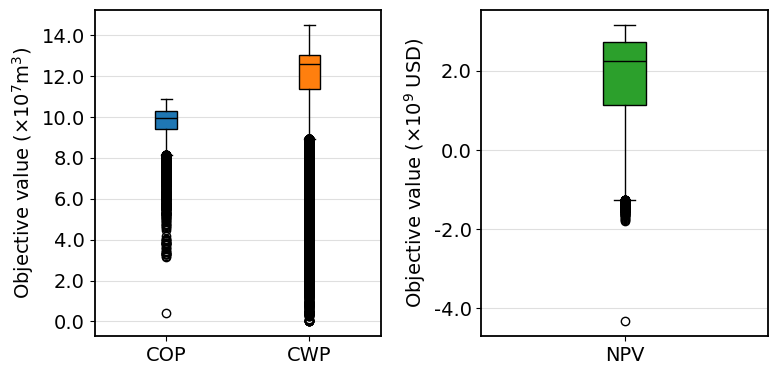

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Extract objective columns
cop = [row[0] for row in objs]
cwp = [row[1] for row in objs]
npv = [row[2] for row in objs]

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=False)

# ---------- COP & CWP ----------
box1 = axes[0].boxplot(
    [cop, cwp],
    tick_labels=["COP", "CWP"],
    showfliers=True,
    patch_artist=True
)

colors = ["tab:blue", "tab:orange"]

for element in ["boxes", "whiskers", "caps", "medians"]:
    plt.setp(box1[element], color="black")

for patch, color in zip(box1["boxes"], colors):
    patch.set_facecolor(color)

axes[0].set_ylabel("Objective value ($\\times 10^7 \\mathrm{m}^3$)")
axes[0].yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: f"{y/1e7:.1f}")
)
axes[0].grid(True, axis="y", alpha=0.4)

# ---------- NPV ----------
box2 = axes[1].boxplot(
    [npv],
    tick_labels=["NPV"],
    showfliers=True,
    patch_artist=True
)

for element in ["boxes", "whiskers", "caps", "medians"]:
    plt.setp(box2[element], color="black")

box2["boxes"][0].set_facecolor("tab:green")

axes[1].set_ylabel("Objective value ($\\times 10^9 \\; \\mathrm{USD}$)")
axes[1].yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{x/1e9:.1f}")
)
axes[1].grid(True, axis="y", alpha=0.4)

plt.tight_layout()
plt.savefig("figures/boxplot_MOU2D.pdf")
plt.show()
